Replicating the analysis in Beiró et al 2004


About the Datasets

    Date format:
    The hour column is computed by integer dividing the timestamp by 3600 seconds. 
    For example, the first line of the network for "noaltarifazo_ruidazonacional" 
    has hour=429531. 
    This means a timestamp of 429531*3600=1546311600 and it implies that the pair 
    of hashtags (h1, h2) was used in the hour comprised between timestamp 1546311600 
    and timestamp 1546315200, which corresponds to "1 January 2019 0:00:00 - 0:00:00". 
    The event itself was centered on 4 January 2019.


Exercise goal - replicate Figure 6 
- Create a network per hour where:
    Nodes are hashtags and nodes connect when the same user mentioned them
- Calculate modularity (use networkix.community) and nestedness


## Load data and import Packages

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import numpy as np
import networkx as nx
from nestedness_master.nestedness_calculator import NestednessCalculator

from glob import glob
from tqdm import tqdm

In [15]:
# Data paths
n9_path = 'D:/FV/Personal/VIU/clean_data/9n_9ngranmarchaporlajusticia.csv'
noAlTar_path = 'D:/FV/Personal/VIU/clean_data/noaltarifazo_ruidazonacional.csv'

In [21]:
folder_path = 'D:/FV/Personal/VIU/clean_data/link_lists_after_cleaning/*hashNodes*'

files = glob(folder_path)

files = [f for f in files if '.csv' not in f]
file_path = files[0]

complete_df = pd.DataFrame()

for file_path in tqdm(files):
    if '.csv' in file_path:
        continue

    hour = file_path.split('_link_list.pickle')[0].split('_')[-2]
    database = file_path.split('\\')[-1].split('_')[0]

    with open(file_path, 'rb') as f:
        link_list = pickle.load(f)

    clean_link_list = [tup for tup in link_list if tup[2] != 0]

    clean_link_arr = np.array(clean_link_list)
    nodes = np.concatenate([clean_link_arr[:,0], clean_link_arr[:,1]])

    G = nx.Graph()
    G.add_weighted_edges_from(clean_link_list)

    # Calculate modularity according to louvain method
    louvain_c = nx.community.louvain_communities(G)
    modularity = nx.community.modularity(G, louvain_c)

    # Calculate Nestedness
    mat = nx.adjacency_matrix(G, weight = 'None').todense()
    nestedness = NestednessCalculator(mat).nodf(mat)

    # get components
    components = sorted(nx.connected_components(G), key=len, reverse=True)
    nr_of_components = len(components)

    # Get database
    if database == '9n':
        db_df = pd.read_csv(n9_path)
        db_df['hashtag'] = db_df.hashtag.str.lower(
                        ).str.normalize('NFKD'
                        ).str.encode('ascii', errors='ignore'
                        ).str.decode('utf-8')
        db_hour_df = db_df[db_df.hour == int(hour)]

    elif database == 'no':
        db_df = pd.read_csv(noAlTar_path)
        db_df['hashtag'] = db_df.hashtag.str.lower(
                        ).str.normalize('NFKD'
                        ).str.encode('ascii', errors='ignore'
                        ).str.decode('utf-8')
        db_hour_df = db_df[db_df.hour == int(hour)]

    # Get nr of users in network
    total_nr_of_users = db_hour_df[db_hour_df.hashtag.isin(nodes)].user.count()
    total_nr_of_unique_users = db_hour_df[db_hour_df.hashtag.isin(nodes)].user.nunique()

    # Get nr of users per component
    nr_of_users_per_c =  [db_hour_df.loc[db_hour_df.hashtag.isin(list(comp)), 'user'].count() for comp in components]
    nr_of_unique_users_per_c =  [db_hour_df.loc[db_hour_df.hashtag.isin(list(comp)), 'user'].nunique() for comp in components]

    # Get nr of users in giant component and in network
    nr_of_users_in_giant_c = nr_of_users_per_c[0]
    nr_of_unique_users_in_giant_c = nr_of_unique_users_per_c[0]


    # Put Daa in Dataframe
    hour_df = pd.DataFrame([database, hour, modularity, nestedness, nr_of_components, 
                            total_nr_of_users, total_nr_of_unique_users,
                            nr_of_users_in_giant_c, nr_of_unique_users_in_giant_c,
                            nr_of_users_per_c, nr_of_unique_users_per_c]).T

    complete_df = pd.concat([complete_df, hour_df])



complete_df.columns = ['db', 'hour', 'mod', 'nest', 'n_comp', 
                       'total_nr_of_users', 'total_nr_of_unique_users', 
                       'nr_of_users_in_giant_c', 'nr_of_unique_users_in_giant_c',
                    'nr_of_users_per_c', 'nr_of_unique_users_per_c']

complete_df.to_csv('D:/FV/Personal/VIU/clean_data/graph_metrics_hashNodes_clean.csv')

complete_df

100%|██████████| 357/357 [07:11<00:00,  1.21s/it]


OSError: Cannot save file into a non-existent directory: 'D:\FV\VIU\clean_data'

## Figure 6

In [40]:
graph_metrics_path = 'D:/FV/Personal/VIU/clean_data/graph_metrics_hashNodes_clean.csv'
# graph_metrics_path = 'D:/FV/Personal/VIU/clean_data/graphMetrics_hashNodes.csv'

graph_metrics_df = pd.read_csv(graph_metrics_path, index_col=0)

graph_metrics_df['date'] = pd.to_datetime(graph_metrics_df.hour * 3600, unit='s', 
                                          )

graph_metrics_df.head()

,db,hour,mod,nest,n_comp,total_nr_of_users,total_nr_of_unique_users,nr_of_users_in_giant_c,nr_of_unique_users_in_giant_c,nr_of_users_per_c,nr_of_unique_users_per_c,date
0,9n,436984,0.638264,0.049088,38,2328,584,2158,543,"[2158, 9, 6, 9, 5, 5, 6, 7, 8, 4, 10, 3, 6, 4,...","[543, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2...",2019-11-07 16:00:00
0,9n,436985,0.557351,0.064994,28,3557,813,3439,779,"[3439, 15, 6, 8, 10, 6, 8, 3, 5, 3, 3, 2, 2, 2...","[779, 2, 1, 1, 1, 3, 1, 1, 2, 1, 1, 1, 1, 1, 2...",2019-11-07 17:00:00
0,9n,436986,0.587093,0.061329,37,3005,766,2856,724,"[2856, 21, 6, 4, 4, 4, 4, 3, 3, 9, 3, 3, 6, 3,...","[724, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1...",2019-11-07 18:00:00
0,9n,436987,0.523465,0.065223,45,3050,729,2825,674,"[2825, 8, 8, 31, 8, 5, 5, 8, 4, 12, 20, 3, 3, ...","[674, 1, 1, 1, 4, 1, 1, 1, 1, 2, 3, 1, 1, 1, 1...",2019-11-07 19:00:00
0,9n,436988,0.593661,0.057229,32,3507,720,3330,679,"[3330, 14, 9, 9, 15, 12, 14, 8, 9, 9, 12, 4, 3...","[679, 1, 2, 2, 1, 1, 1, 3, 1, 4, 3, 1, 1, 1, 1...",2019-11-07 20:00:00


C:\Users\neuro\AppData\Local\Temp\ipykernel_20368\3940626464.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'high_modularity'] = 'no'


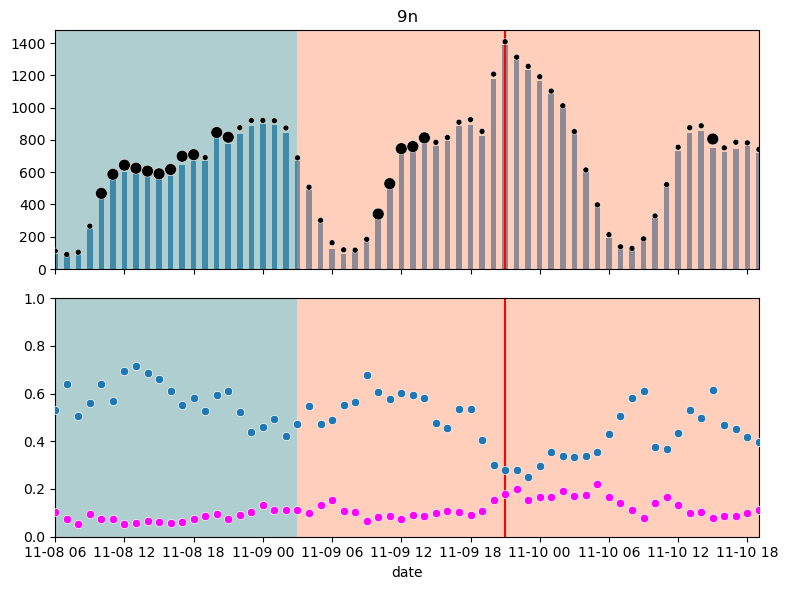

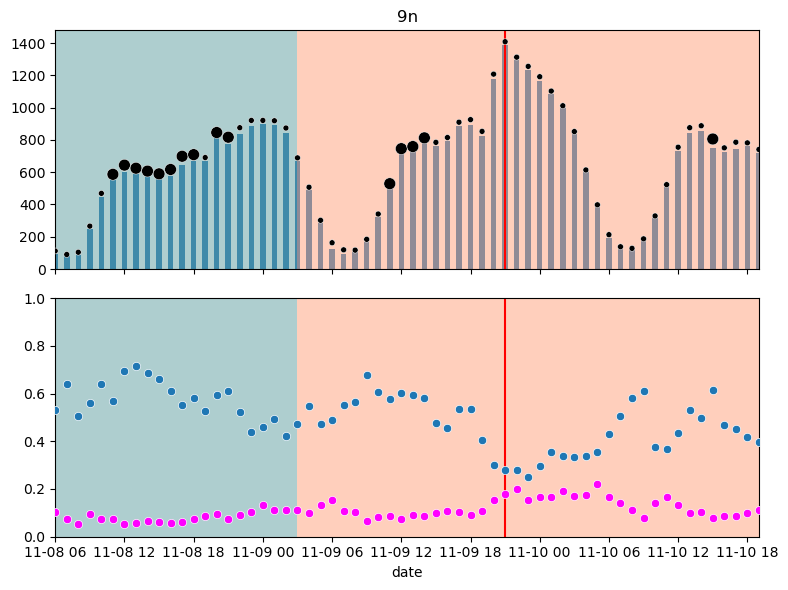

In [41]:
db = '9n'

df = graph_metrics_df.loc[(graph_metrics_df.db == db) & 
                             (graph_metrics_df.date <= '2019-11-10 19:00') & 
                             (graph_metrics_df.date >= '2019-11-08 06:00'), :]


def plot_figure6(df, db, total_users = True):

    fig, axes = plt.subplots(2,1, figsize = [8, 6],sharex=True)

    df.loc[:,'high_modularity'] = 'no'
    if total_users:
        df.loc[(df['mod'] > .55) & (df.total_nr_of_users > 0.2*df.total_nr_of_users.max()), 'high_modularity'] = 'yes'
    else:
        df.loc[(df['mod'] > .55) & (df.total_nr_of_unique_users > 0.2*df.total_nr_of_unique_users.max()), 'high_modularity'] = 'yes'

    df1 = df[['date', 'total_nr_of_unique_users', 'high_modularity']].melt(id_vars = ['date', 'high_modularity'])
    df1['variable'] = df1.variable.replace({'nr_of_unique_users_in_giant_c': 'Nº of users in the giant component',
                                          'total_nr_of_unique_users':  'Nº of users'})
    # Axis 0
    sns.scatterplot(data = df1, x = 'date', y = 'value', hue= 'variable', 
                    # style='high_modularity', style_order = ['yes', 'no'],
                    size = 'high_modularity', size_order = ['yes', 'no'],
                    palette = [ 'black'], zorder = 5, ax = axes[0])
    
    df2 = df[['date', 'nr_of_unique_users_in_giant_c',]]

    axes[0].bar(df2['date'], df2['nr_of_unique_users_in_giant_c'], 
                color=sns.color_palette()[0], width=0.02, label = 'Nº of users\nin giant component')

    sns.move_legend(
        axes[0], loc='upper left',
        bbox_to_anchor=(0.01, 0.98), ncol=2, title=None,
    )


    # sns.scatterplot(data = df, x = 'date', y = 'nr_of_unique_users_in_giant_c', style='high_modularity', color = 'red', zorder = 5, ax = axes[0], label = 'Nº of users in the giant component')
    # sns.scatterplot(data = df, x = 'date', y = 'total_nr_of_unique_users', style='high_modularity', zorder = 5, color = 'black', ax = axes[0], label = 'Nº of users')
    # Axis 1
    sns.scatterplot(data = df, x = 'date', y = 'mod', zorder = 5, ax = axes[1], label = 'Modularity')
    sns.scatterplot(data = df, x = 'date', y = 'nest', color = 'magenta', zorder = 5, ax = axes[1], label = 'Nestedness')
    # Add Axes spans and annotations
    if db == '9n':
        axes[0].axvline(x = pd.to_datetime('2019-11-09 21:00'), color = 'red')
        axes[0].axvspan(df.date.min(), '2019-11-09 03:00', facecolor='cadetblue', alpha=0.5)
        axes[0].axvspan('2019-11-09 03:00', df.date.max(), facecolor='lightsalmon', alpha=0.5)
        axes[0].set_xlim([df.date.min(), df.date.max() ]);
        # axes[0].legend(bbox_to_anchor=(0.01, 0.98), loc='upper left', )
        # ==========
        axes[1].axvline(x = pd.to_datetime('2019-11-09 21:00'), color = 'red')
        axes[1].axvspan(df.date.min(), '2019-11-09 03:00', facecolor='cadetblue', alpha=0.5)
        axes[1].axvspan('2019-11-09 03:00', df.date.max(), facecolor='lightsalmon', alpha=0.5)
        axes[1].set_xlim([df.date.min(), df.date.max() ]);
        axes[1].set_ylim([0,1]);
        axes[1].legend(bbox_to_anchor=(0.01, 0.98), loc='upper left', )
        for ax in axes:
            ax.set_ylabel('')
        axes[0].set_title('9n')

    elif db== 'no':
        axes[0].axvline(x = pd.to_datetime('2019-01-05 00:00'), color = 'red')
        axes[0].axvspan(df.date.min(), '2019-01-04 03:00', facecolor='cadetblue', alpha=0.5)
        axes[0].axvspan('2019-01-04 03:00', df.date.max(), facecolor='lightsalmon', alpha=0.5)
        axes[0].set_xlim([df.date.min(), df.date.max() ]);
        # axes[0].legend(bbox_to_anchor=(0.01, 0.98), loc='upper left', )
        # ==========
        axes[1].axvline(x = pd.to_datetime('2019-01-05 00:00'), color = 'red')
        axes[1].axvspan(df.date.min(), '2019-01-04 03:00', facecolor='cadetblue', alpha=0.5)
        axes[1].axvspan('2019-01-04 03:00', df.date.max(), facecolor='lightsalmon', alpha=0.5)
        axes[1].set_xlim([df.date.min(), df.date.max() ]);
        axes[1].set_ylim([0,1]);
        axes[1].legend(bbox_to_anchor=(0.01, 0.98), loc='upper left', )
        for ax in axes:
            ax.set_ylabel('')
        axes[0].set_title('No al tarifazo')

    for ax in axes:
        ax.legend_.remove()

    plt.tight_layout()

    return fig, axes

fig, axes = plot_figure6(df, db, total_users=False)
plt.savefig('D:/FV/Personal/VIU/figures/f6_9n_clean.png',transparent=True,bbox_inches='tight',pad_inches=0)
# plt.savefig('D:/FV/Personal/VIU/figures/f6_9n.png',transparent=True,bbox_inches='tight',pad_inches=0)

fig, axes = plot_figure6(df, db, total_users=True)
plt.savefig('D:/FV/Personal/VIU/figures/f6_9n_clean_totalUsers_clean.png',transparent=True,bbox_inches='tight',pad_inches=0)
# plt.savefig('D:/FV/Personal/VIU/figures/f6_9n_clean_totalUsers.png',transparent=True,bbox_inches='tight',pad_inches=0)

C:\Users\neuro\AppData\Local\Temp\ipykernel_20368\3940626464.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'high_modularity'] = 'no'


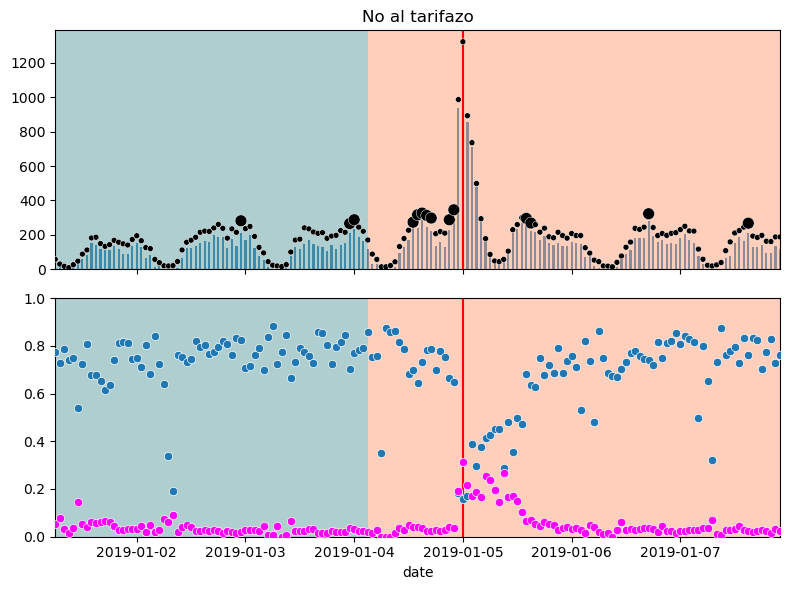

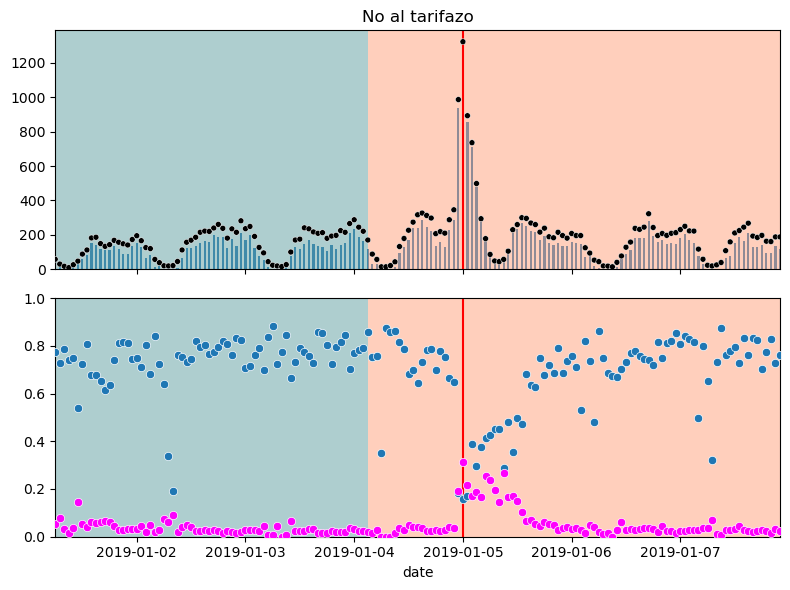

In [42]:

db = 'no'

df = graph_metrics_df.loc[(graph_metrics_df.db == db) & 
                             (graph_metrics_df.date >= '2019-01-01 06:00') & 
                             (graph_metrics_df.date <= '2019-01-07 22:00'), :]


fig, axes = plot_figure6(df, db, total_users=False)
plt.savefig('D:/FV/Personal/VIU/figures/f6_no_al_tarifazo_clean.png',transparent=True,bbox_inches='tight',pad_inches=0)
# plt.savefig('D:/FV/Personal/VIU/figures/f6_no_al_tarifazo.png',transparent=True,bbox_inches='tight',pad_inches=0)

fig, axes = plot_figure6(df, db, total_users=True)
plt.savefig('D:/FV/Personal/VIU/figures/f6_no_al_tarifazo_clean_totalUsers.png',transparent=True,bbox_inches='tight',pad_inches=0)
# plt.savefig('D:/FV/Personal/VIU/figures/f6_no_al_tarifazo_totalUsers.png',transparent=True,bbox_inches='tight',pad_inches=0)
